In [4]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from utils.data_io import create_time_bins, get_cam_timestamps, load_ONE, get_experiment_path, get_dlc_df, get_rotary_position, temporally_align_variable, preprocess_dlc_data
from utils.behavioral_analysis import calculate_median_position
from utils.visualization import plot_single_session, plot_all_sessions
from utils.pipeline import load_and_process_session, analyze_single_session, analyze_multiple_sessions
from utils.statistical_testing import categorise_neurons
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from types import SimpleNamespace as Bunch

In [60]:
subject_id = 'EB036'
date = '2024-03-20'

neck: 1142 NaN frames for x (0.4%)
neck: 1142 NaN frames for y (0.4%)
mid_back: 1948 NaN frames for x (0.6%)
mid_back: 1948 NaN frames for y (0.6%)
mouse_center: 113 NaN frames for x (0.0%)
mouse_center: 113 NaN frames for y (0.0%)
mid_backend: 547 NaN frames for x (0.2%)
mid_backend: 547 NaN frames for y (0.2%)
mid_backend2: 9843 NaN frames for x (3.3%)
mid_backend2: 9843 NaN frames for y (3.3%)
mid_backend3: 49948 NaN frames for x (16.6%)
mid_backend3: 49948 NaN frames for y (16.6%)
Processing frame 10/10
=== Cross-validation debug ===
half point: 25072
First half wheel running: 8054
Second half wheel running: 10930
First half wheel speed range: 0.00 to 64.51
Second half wheel speed range: 0.00 to 74.07


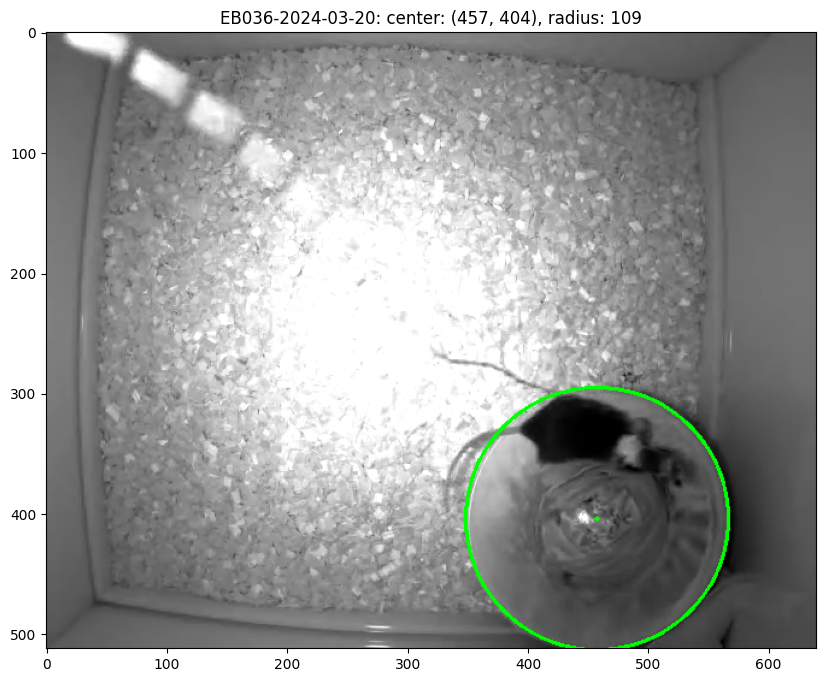

In [61]:
sesh =load_and_process_session(subject_id, date, target_freq=10)
sesh = analyze_single_session(sesh)

In [ ]:
oa_speed_bins = np.linspace(0, np.nanmax(sesh.oa_speed), num=10)
oa_speed_bin_centers = 0.5 * (oa_speed_bins[:-1] + oa_speed_bins[1:])
n_neurons = sesh.spike_counts.shape[0]
oa_firing_rates = np.zeros((n_neurons, len(oa_speed_bin_centers)))
oa_speed_indices = np.digitize(sesh.oa_speed, oa_speed_bins) -1

dt = 0.1


for i in range (len(oa_speed_bin_centers)):
    idx =oa_speed_indices == i
    if np.any(idx):
        occupancy = np.sum(idx) * dt
        spikes_in_bin = sesh.spike_counts[:,idx].sum(axis=1)
        oa_firing_rates[:,i] = spikes_in_bin / occupancy
    else:
        oa_firing_rates[:,i] = np.nan

In [69]:
wh_speed_bins = np.linspace(0, np.nanmax(sesh.wh_speed), num=10)
wh_speed_bin_centers = 0.5 * (wh_speed_bins[:-1] + wh_speed_bins[1:])

wh_firing_rates = np.zeros((n_neurons, len(wh_speed_bin_centers)))
wh_speed_indices = np.digitize(sesh.wh_speed, wh_speed_bins) -1

dt = 0.1


for i in range (len(wh_speed_bin_centers)):
    idx =wh_speed_indices == i
    if np.any(idx):
        occupancy = np.sum(idx) * dt
        spikes_in_bin = sesh.spike_counts[:,idx].sum(axis=1)
        wh_firing_rates[:,i] = spikes_in_bin / occupancy
    else:
        wh_firing_rates[:,i] = np.nan